<a href="https://colab.research.google.com/github/Calebmonroe/DS2/blob/main/HW8_MLPs_and_Neural_Networks_nosols.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework #8 - Multilayer Perceptrons and Neural Networks

This assignment will explore the application of MLP Networks to several classification problems





# Package Imports

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.mixture import GaussianMixture


from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_moons
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV



#define the default font sizes to make the figures prettier
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

##Function Definitions

In [2]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
#    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_absolute_error: ', round(mean_absolute_error,4))
#    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [3]:
def class_performance(xdata,ydata,model):
  print("\n\n",model)
# Classifiers with the score method output accuracy by default
  acc = model.score(xdata,ydata)
  predy = model.predict(xdata)
  prec, rec, fscore, supp = precision_recall_fscore_support(ydata, predy, average=None, zero_division=0)
  print("\nmodel accuracy on supplied data:\t", acc.round(3))
  print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3), "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp)

# Exercise 1 - MLP on obesity data

Train a Multilayer Perceptron network that is able to predict a person's degree of obesity based on their eating and exercise habits.  

* Once your model is trained, evaluate its accuracy on the training and test data.  Present and discuss the target-level performance of your model using **precision, recall, F1 scores, and the confusion matrix.**  

* Compare the performance of your model to the Decision Tree you trained on the same dataset (exercise 2 from HW #7, you may use my solution).

* Present your final discussion/comparison in a separate Markdown cell at the end of your analysis

### Preparing the dataframe

This dataset was retrieved from Kaggle.  It contains peronal demographic information and attributes related to eating habits for 2111 individuals.  The question is, **how well can we predict obesity based on calorie intake and expenditure**

Personal Demographic features are:
Gender, Age, Height, Weight, family history

Attributes related to eating habits:
* FAVC - Frequent of consumption of high caloric food (yes/no)
* FCVC - Frequency of consumption of vegetables (servg per day)
* NCP - Number of main meals (1-4)
* CAEC - Consumption of food between meals (Sometimes', 'Frequently', 'Always', 'no')
* SMOKE - Smoking (yes/no)
* CH20 - Daily consumption of water (1-3 L)
* SCC - Caloric consumption monitoring (yes/no)
* FAF - Physical activity frequency (0-3 hours)
* TUE - Time using technology devices (0-2 hours)
* CALC - Consumption of alcohol ('no', 'Sometimes', 'Frequently', 'Always')
* MTRANS - Transportation used ('Public_Transportation', 'Walking', 'Automobile', 'Motorbike', 'Bike')
* NObeyesdad - Degree of obesity (Underweight, Normal, Overweight_I,
 Overweight_II, Obesity_I, Obesity_II, Obesity_III)

In [4]:
#df = pd.read_csv('ObesityDataSet.csv')

web_path = 'http://public.gettysburg.edu/~rjohnson/ds325/' #if using data over web
df_o = pd.read_csv(web_path+'ObesityDataSet.csv')

In [5]:
#df_o.info()

Our task will be to train a classifier that can predict a person's degree of obesity based on their eating and exercise habits.  Since we want a person's obesity class to be a function only of these variables, we will intentionally ignore Age, Height, and Weight (which most certainly are correlated with obesity).  The strategy will be to:

* convert categorical features to numerical
* examine variable distribution for stratifying purposes
* create pipeline including standard scaler
* train svm classifier


In [6]:
# rename columns
df_o.rename(columns={"family_history_with_overweight": "hist"}, inplace=True)
df_o.rename(columns={"NObeyesdad": "obes"}, inplace=True)

In [7]:
# I'm manually encoding the obesity classification because when I used
# LabelEncoder(), it put them in alphabetical order, which wasn't helpful

df_o['obes'].replace({'Insufficient_Weight':0, 'Normal_Weight':1,
                                'Overweight_Level_I':2, 'Overweight_Level_II':3,
                                'Obesity_Type_I':4, 'Obesity_Type_II':5,
                                'Obesity_Type_III':6},inplace=True)

df_o['CAEC'].replace({'no':0, 'Sometimes':1,
                                'Frequently':2, 'Always':3}, inplace=True)

In [8]:
# here we encode all of the non-numerical features
# using LabelEncoder and replace our dataframe
le_hist = LabelEncoder()
dft = le_hist.fit_transform(df_o['hist'])
df_o['hist'] = dft

le_gen = LabelEncoder()
dft = le_gen.fit_transform(df_o['Gender'])
df_o['Gender'] = dft

le_favc = LabelEncoder()
dft = le_favc.fit_transform(df_o['FAVC'])
df_o['FAVC'] = dft

le_caec = LabelEncoder()
dft = le_caec.fit_transform(df_o['CAEC'])
df_o['CAEC'] = dft

le_smoke = LabelEncoder()
dft = le_smoke.fit_transform(df_o['SMOKE'])
df_o['SMOKE'] = dft

le_scc = LabelEncoder()
dft = le_scc.fit_transform(df_o['SCC'])
df_o['SCC'] = dft

le_calc = LabelEncoder()
dft = le_calc.fit_transform(df_o['CALC'])
df_o['CALC'] = dft

le_mtrans = LabelEncoder()
dft = le_mtrans.fit_transform(df_o['MTRANS'])
df_o['MTRANS'] = dft

In [9]:
# getting rid of demongraphic info
df_o.drop(['Age', 'Height', 'Weight'], axis=1, inplace=True)

In [10]:
feat = df_o.drop('obes', axis=1, inplace=False)
targ = df_o['obes']

X_train, X_test, y_train, y_test = train_test_split(feat, targ, test_size=0.2,
                                                   random_state=42)

# Solution

In [12]:
scaler = StandardScaler() #establishing standard scaler
X_train_scaled = scaler.fit_transform(X_train) #transforming X_train so that it is now scaled

X_test_scaled = scaler.transform(X_test) #transforming X_test so that it is now scaled

In [13]:
mlp = MLPClassifier(hidden_layer_sizes=[100], max_iter=10_000,#making pipeline
                        random_state=42)
mlp_clf = make_pipeline(StandardScaler(), mlp)
mlp_clf.fit(X_train_scaled, y_train)#fitting model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[100], max_iter=10000,
                               random_state=42))])

In [15]:
mlp_predictions_train = mlp_clf.predict(X_train_scaled)  # Making initial predictions on training data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_train_scaled, y_train))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_train, mlp_predictions_train, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_train, mlp_predictions_train)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.9727488151658767
Precision:	 [0.982 0.982 0.982 0.974 0.967 0.929 0.996] 
Recall:		 [0.995 0.978 0.932 0.954 0.967 0.983 1.   ] 
Fscore:		 [0.989 0.98  0.956 0.964 0.967 0.955 0.998] 
Support:	 [216 225 234 240 273 239 261]

Confusion Matrix:
[[215   1   0   0   0   0   0]
 [  0 220   1   2   1   1   0]
 [  4   1 218   1   3   7   0]
 [  0   2   1 229   4   4   0]
 [  0   0   1   1 264   6   1]
 [  0   0   1   2   1 235   0]
 [  0   0   0   0   0   0 261]]


In [16]:
mlp_predictions_test = mlp_clf.predict(X_test_scaled)  # Making initial predictions on testing data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_test_scaled, y_test))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_test, mlp_predictions_test, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_test, mlp_predictions_test)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.7257683215130024
Precision:	 [0.807 0.527 0.475 0.638 0.826 0.74  1.   ] 
Recall:		 [0.821 0.468 0.5   0.6   0.731 0.931 1.   ] 
Fscore:		 [0.814 0.496 0.487 0.619 0.776 0.824 1.   ] 
Support:	 [56 62 56 50 78 58 63]

Confusion Matrix:
[[46  5  4  0  0  1  0]
 [ 4 29 15  6  4  4  0]
 [ 6 11 28  4  2  5  0]
 [ 0  4  5 30  5  6  0]
 [ 1  5  7  5 57  3  0]
 [ 0  1  0  2  1 54  0]
 [ 0  0  0  0  0  0 63]]


# Results:
The results from the above models vary slightly from each other. In specific, the model's predictions on the training set of data are significantly better than the prediction on the testing set of data. The models accuracy on the test set is 97% which drastically outperforms the model's predictions on the testing data which yield an accuracy of only 72.58%. Additionally, the values for the precision, recall, and F1 scores all reported higher values on the testing set predictions than the training set of predictions. This implies that the model overfits the data on the training set and may not be great at generalizing to unseen data. Even though this is the case, the model seems to perform better on both the training and testing set, when compared to the results from HW 7 problem 2 with the same data set. Both accuracy scores are higher with the MLP model than the decision tree model, which yields an accuracy score of 78.6% and 70% respectively. The other metrics also produce lesser values when compared to the MLP model as well, which implies that the MLP model is a better predictor.

# Mastery Question 1

Construct an MLP Network that can attain >90% accuracy on both the training and test sets for the above obesity data.

# Exercise 2 - A MLP classifier on interleaved data (make moons)

In the following problem, I have used Sklearn's **make_moons** method in order to generate 4 interleaving datasets.  Your job is to train and optimize and MLP classifier network to the membership of each datapoint to its particular target group.

* Evaluate your best model's accuracy on the training and test data.  Present and discuss the **precision, recall, F1 scores, and the confusion matrix**

* Compare this model's performance to the best model from exercise 3 in HW #7 (you may use my solutions)
  
* Present your final discussion/comparison in a separate Markdown cell at the end of your analysis

## Setup

In [17]:
# some helper functions for plotting the moons data
def plot_dataset1(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "yo")
    plt.plot(X[:, 0][y==3], X[:, 1][y==3], "r*")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)
#    plt.colorbar() # added colorbar showing decision function values


def plot_dataset2(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "kx")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "kx")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "kx")
    plt.plot(X[:, 0][y==3], X[:, 1][y==3], "kx")
    plt.axis(axes)
    plt.grid(True)


### Generating Moons data

In [18]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.15, random_state=42)

X2, y2 = make_moons(n_samples=200, noise=0.15, random_state=42)

# change numbers
y2 = y2+2

# Define the angle of rotation in radians
theta = np.radians(90)

# Calculate the sine and cosine of the angle
c, s = np.cos(theta), np.sin(theta)

# Create the rotation matrix
R = np.array(((c, -s), (s, c)))

# Define the vector to be rotated
v = np.array(X2)

# Rotate the vector using the rotation matrix
X2r = np.dot(v, R)

for i in range(len(X)):
  if y[i] == 0:
    X[i,1] = X[i,1]-0.25
  if y[i] == 1:
    X[i,1] = X[i,1]-1

for i in range(len(X2r)):
  if y2[i] == 2:
    X2r[i,0] = X2r[i,0]+0.5
  if y2[i] == 3:
    X2r[i,0] = X2r[i,0]-0.25

xall = np.concatenate((X, X2r), axis=0)
yall = np.concatenate((y, y2), axis=None)



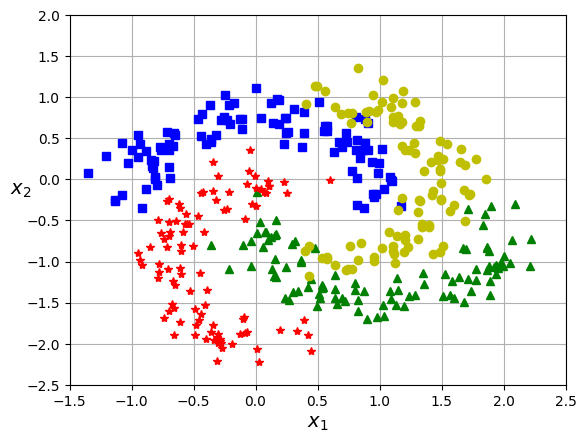

In [19]:
plot_dataset1(xall, yall, [-1.5, 2.5, -2.5, 2])

plt.show()

In [20]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(xall, yall, test_size=0.2,
                                                   random_state=42)

# Solution

In [22]:
scaler = StandardScaler() #establishing standard scaler
X_train_scaled = scaler.fit_transform(X_train) #transforming X_train so that it is now scaled

X_test_scaled = scaler.transform(X_test) #transforming X_test so that it is now scaled

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=[100], max_iter=10_000,#making pipeline
                        random_state=42)
mlp_clf = make_pipeline(StandardScaler(), mlp)
mlp_clf.fit(X_train_scaled, y_train)#fitting model using created pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[100], max_iter=10000,
                               random_state=42))])

In [24]:
mlp_predictions_train = mlp_clf.predict(X_train_scaled)  # Making initial predictions on training data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_train_scaled, y_train))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_train, mlp_predictions_train, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_train, mlp_predictions_train)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.975
Precision:	 [0.986 0.976 0.935 1.   ] 
Recall:		 [0.972 0.964 0.96  1.   ] 
Fscore:		 [0.979 0.97  0.947 1.   ] 
Support:	 [72 84 75 89]

Confusion Matrix:
[[70  0  2  0]
 [ 0 81  3  0]
 [ 1  2 72  0]
 [ 0  0  0 89]]


In [25]:
mlp_predictions_test = mlp_clf.predict(X_test_scaled)  # Making initial predictions on testing data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_test_scaled, y_test))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_test, mlp_predictions_test, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_test, mlp_predictions_test)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.925
Precision:	 [0.962 0.938 0.893 0.9  ] 
Recall:		 [0.893 0.938 1.    0.818] 
Fscore:		 [0.926 0.938 0.943 0.857] 
Support:	 [28 16 25 11]

Confusion Matrix:
[[25  0  3  0]
 [ 0 15  0  1]
 [ 0  0 25  0]
 [ 1  1  0  9]]


# Discussion
This model appears to perform slightly better than the best model in HW7, which is the Decision Tree model. The decision tree model in HW7 yields a accuracy score of .953 on the training set and .875 on the test set, which are both slightly less than the values listed in this model. Additionally, some of the other metrics report very similar values, but the MLP model provides better results overall.

# Mastery Question 2

Produce a position plot of the above moons data (separately for training and testing), highlighting all of the points that were incorrectly classified by your model.

# Exercise 3 - A Multilayer Perceptron classifier (MNIST)

* Use PCA dimensional reduction on the the provided MNIST dataset to train and evaluate an MLP classifier.  

* Evaluate your best model's accuracy on the training and test data.  Present and discuss the **precision, recall, F1 scores, and the confusion matrix**
  
* Present your final discussion/comparison in a separate Markdown cell at the end of your analysis

###MNIST dataset (28x28)

Using Keras, we can retrieve the MNIST data.  The data is ordered so that the first 60000 images are meant for training and the last 10000 are for testing.  The following code already knows this and will properly split the data according to that information.

In [26]:
from keras.datasets import mnist

# X_train will be 60000 x 28 x 28 images, y_train will be 10000 target ids
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [27]:
y_train.shape  #
#y_test.shape

(60000,)

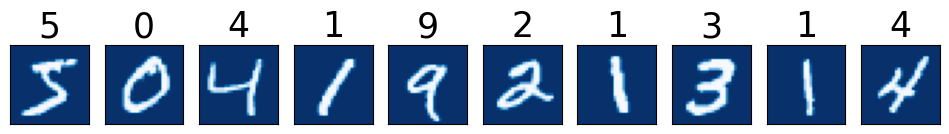

In [28]:
# checking the first 6 targets
plt.close('all')
fig = plt.figure(figsize=(12, 3))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[]) # make a bunch of side by side subplots
    ax.imshow(X_train[idx], cmap='Blues_r') # output the training image; (imshow can recognize)
    ax.set_title(str(y_train[idx]),fontsize=25) # output the target number

In [29]:
#X_train[0].shape

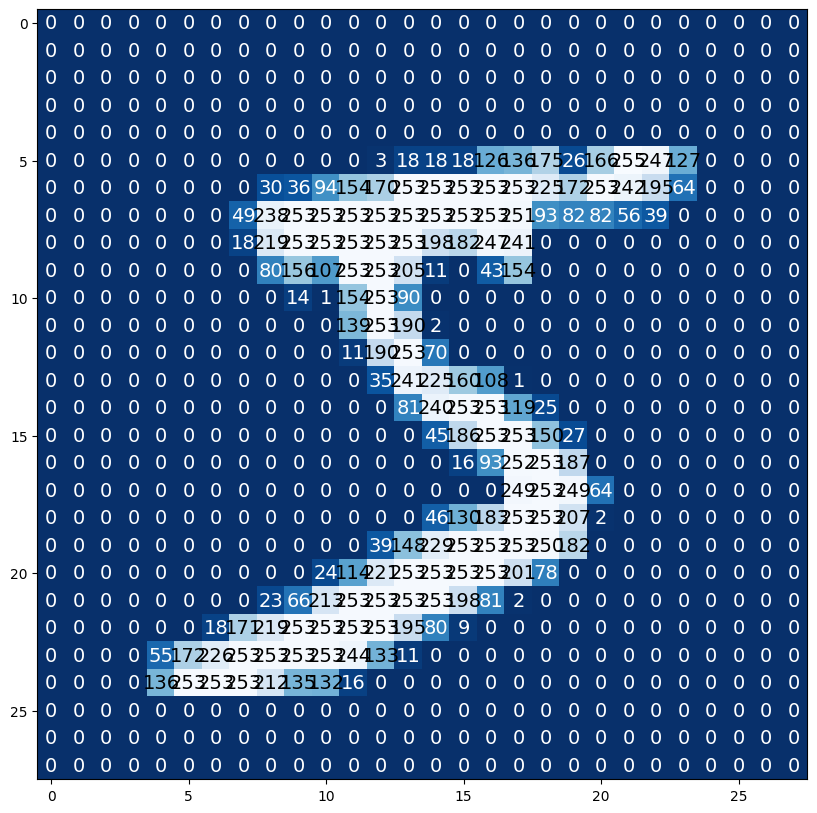

In [30]:
# here is a closeup of what an image looks like
plt.close('all')
img = X_train[0]
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='Blues_r')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
#plt.grid();
plt.show()


This dataset is too large to work with easily in its current form.  With over 47 million data points (60000*784 =4.7e7), any machine learning algorithm will struggle to process them quickly.  

Using PCA, we can reduce the MNIST data down to however many dimensions we wish.

An alternate form for calling PCA is not to define the number of components, but rather to say what fraction of the variance you want to maintain, and it will select the minimum number of principle components that result in that fraction.  

In [31]:
# need to resize the data to make it 2D

Xr_train = np.resize(X_train, (60000, 784))
#Xr_train.shape

Xr_test = np.resize(X_test, (10000, 784))
#Xr_test.shape

# Solution

In [35]:
from sklearn.decomposition import PCA #importing necessary material
pca = PCA(n_components=0.95)  #retain 95% of the variance
Xr_train_pca = pca.fit_transform(Xr_train) #transforming / fitting x train and test using pca
Xr_test_pca = pca.transform(Xr_test)

In [38]:
X_train_pca, X_test_pca, y_train, y_test = train_test_split(Xr_train_pca, y_train, test_size=0.2, random_state=42)
# train test split using new pca variables

In [43]:
mlp = MLPClassifier(hidden_layer_sizes=[50], max_iter=10_000, #making PCA pipeline
                        random_state=42)
mlp_clf = make_pipeline(StandardScaler(), mlp)
mlp_clf.fit(X_train_pca, y_train) #fitting the model using the created pipeline


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[50], max_iter=10000,
                               random_state=42))])

In [44]:
mlp_predictions_train = mlp_clf.predict(X_train_pca)  # Making initial predictions on training data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_train_pca, y_train))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_train, mlp_predictions_train, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_train, mlp_predictions_train)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.9999375
Precision:	 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
Recall:		 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
Fscore:		 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 
Support:	 [4748 5420 4784 4912 4666 4317 4741 4966 4691 4755]

Confusion Matrix:
[[4748    0    0    0    0    0    0    0    0    0]
 [   0 5420    0    0    0    0    0    0    0    0]
 [   0    0 4784    0    0    0    0    0    0    0]
 [   0    0    0 4911    0    0    0    0    1    0]
 [   0    0    0    0 4666    0    0    0    0    0]
 [   0    0    0    0    0 4317    0    0    0    0]
 [   0    0    0    0    0    0 4741    0    0    0]
 [   0    0    0    0    1    0    0 4965    0    0]
 [   0    0    0    0    0    0    0    0 4691    0]
 [   0    0    0    0    1    0    0    0    0 4754]]


In [45]:
mlp_predictions_test = mlp_clf.predict(X_test_pca)  # Making initial predictions on testing data

print("Validation vs testing: Model accuracy, precision, recall, f1, and support")
print("Model accuracy on testing data:\t", mlp_clf.score(X_test_pca, y_test))

# Using score method to find accuracy, precision, recall, F1, support scores
prec, rec, fscore, supp = precision_recall_fscore_support(y_test, mlp_predictions_test, average=None)
print("Precision:\t", prec.round(3), "\nRecall:\t\t", rec.round(3),
      "\nFscore:\t\t", fscore.round(3), "\nSupport:\t", supp.round(3))

conf_matrix = confusion_matrix(y_test, mlp_predictions_test)  # Finding and printing confusion matrix for this model
print("\nConfusion Matrix:")
print(conf_matrix)

Validation vs testing: Model accuracy, precision, recall, f1, and support
Model accuracy on testing data:	 0.9540833333333333
Precision:	 [0.979 0.975 0.932 0.951 0.941 0.948 0.97  0.959 0.928 0.956] 
Recall:		 [0.973 0.983 0.944 0.937 0.962 0.944 0.967 0.956 0.927 0.945] 
Fscore:		 [0.976 0.979 0.938 0.944 0.951 0.946 0.969 0.958 0.927 0.95 ] 
Support:	 [1175 1322 1174 1219 1176 1104 1177 1299 1160 1194]

Confusion Matrix:
[[1143    0    3    3    4    4    2    5    7    4]
 [   0 1300   12    1    3    1    1    1    3    0]
 [   2    8 1108   11   10    1    4   14   13    3]
 [   4    2   27 1142    0   16    0    7   17    4]
 [   1    2    4    0 1131    4    5    6    6   17]
 [   4    4    2   15    3 1042    7    3   20    4]
 [   5    2    5    2    9   11 1138    0    5    0]
 [   1    3   18    8    6    3    1 1242    6   11]
 [   5   10   10   13    7   12   15    4 1075    9]
 [   3    3    0    6   29    5    0   13    7 1128]]


# Discussion
The above model performed extremely well when making predictions on the training set, reporting an accuracy score of 99.9%. The model's performance on the testing set was also very effective which reports an accuracy of 95.4%. In addition, the support scores for each set of reported data seemed to be evenly dispersed. This implies that the model correctly classifies a large number of samples and is not biased towards one class over the other in any noticeable way. The model may have overfit to the training data slightly, as the precision, recall, and F1 scores for the training model were either 1 or near 1. The same scores on the testing set of data were slightly less.  


#Mastery Question 3

Use the network model to produce a decision boundary plot, similar to the solution from Mastery Question 1 from HW #6.  Here, you should plot the 2 principle components from the PCA reduction, along with the decision boundary regions for each predicted digit.